<a href="https://colab.research.google.com/github/iqrahussainn/Facial-Emotion-Recognition-/blob/main/DeepLearningEndSemProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from zipfile import ZipFile
from google.colab import drive
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
drive.mount('/content/drive')
zip_path = "/content/drive/MyDrive/FER-2013.zip"
extract_path = "/content/FER-2013"
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset extracted to:", extract_path)

Mounted at /content/drive
Dataset extracted to: /content/FER-2013


In [ ]:
train_path = os.path.join(extract_path, "FER-2013", "train")
test_path = os.path.join(extract_path, "FER-2013", "test")
print("Train folder contents:", os.listdir(train_path))
print("Test folder contents:", os.listdir(test_path))

Train folder contents: ['sad', 'fear', 'surprise', 'happy', 'neutral', 'angry', 'disgust']
Test folder contents: ['sad', 'fear', 'surprise', 'happy', 'neutral', 'angry', 'disgust']


In [ ]:
# Count images in train and test folders
for folder, path in zip(["Train", "Test"], [train_path, test_path]):
    print(f"\n{folder} set image counts:")
    for emotion in os.listdir(path):
        num_images = len(os.listdir(os.path.join(path, emotion)))
        print(f"{emotion}: {num_images} images")


Train set image counts:
sad: 4830 images
fear: 4097 images
surprise: 3171 images
happy: 7215 images
neutral: 4965 images
angry: 3995 images
disgust: 436 images

Test set image counts:
sad: 1247 images
fear: 1024 images
surprise: 831 images
happy: 1774 images
neutral: 1233 images
angry: 958 images
disgust: 111 images


***Data Preprocessing & Augmentation***

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          # pixels 0-1 me scale kar rahe hain
    rotation_range=20,       # rotation
    width_shift_range=0.2,   # horizontal shift
    height_shift_range=0.2,  # vertical shift
    horizontal_flip=True,    # images flip karenge
    zoom_range=0.2           # zoom
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48,48),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(48,48),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


*Compute Class Weights*

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
train_labels = train_generator.classes
# Compute class weights
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
# Convert to dictionary for Keras
class_weights = {i: w for i, w in enumerate(class_weights_values)}
# Display the calculated class weights
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.0266046844269623), 1: np.float64(9.406618610747051), 2: np.float64(1.0010460615781582), 3: np.float64(0.5684387684387684), 4: np.float64(0.8260394187886635), 5: np.float64(0.8491274770777877), 6: np.float64(1.293372978330405)}


***Visualizing the dataset***

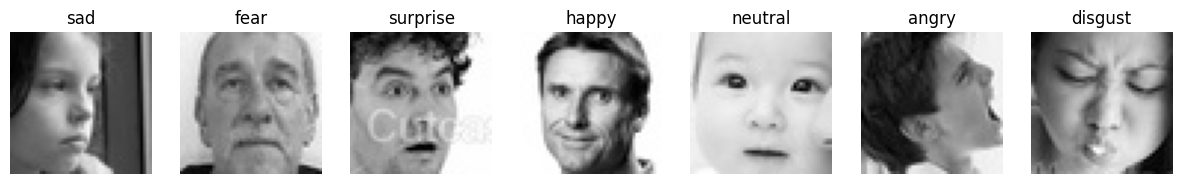

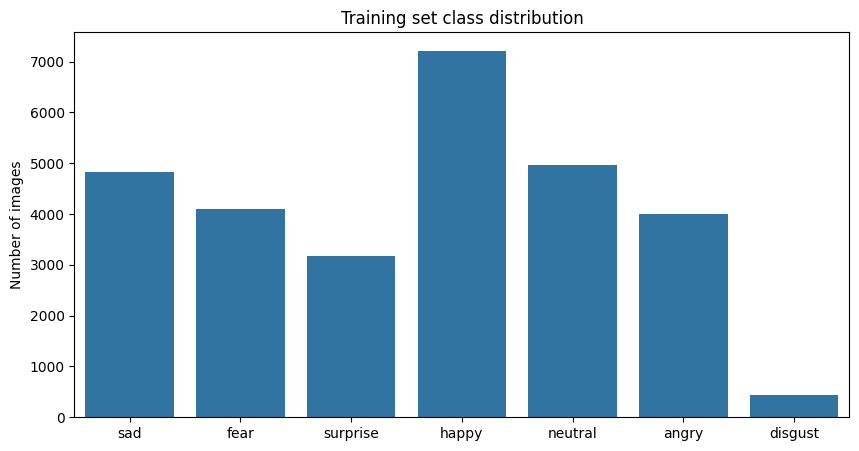

In [ ]:
import random
from tensorflow.keras.preprocessing import image
import seaborn as sns
emotions = os.listdir(train_path)
# Plot 1 sample image per class
plt.figure(figsize=(15,5))
for i, emotion in enumerate(emotions):
    emotion_folder = os.path.join(train_path, emotion)
    img_file = random.choice(os.listdir(emotion_folder))
    img_path = os.path.join(emotion_folder, img_file)
    img = image.load_img(img_path, target_size=(48,48), color_mode='grayscale')

    plt.subplot(1, len(emotions), i+1)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')
plt.show()
# Plot class distribution
train_counts = {emotion: len(os.listdir(os.path.join(train_path, emotion))) for emotion in emotions}
plt.figure(figsize=(10,5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Training set class distribution")
plt.ylabel("Number of images")
plt.show()

***visualization augmented images***

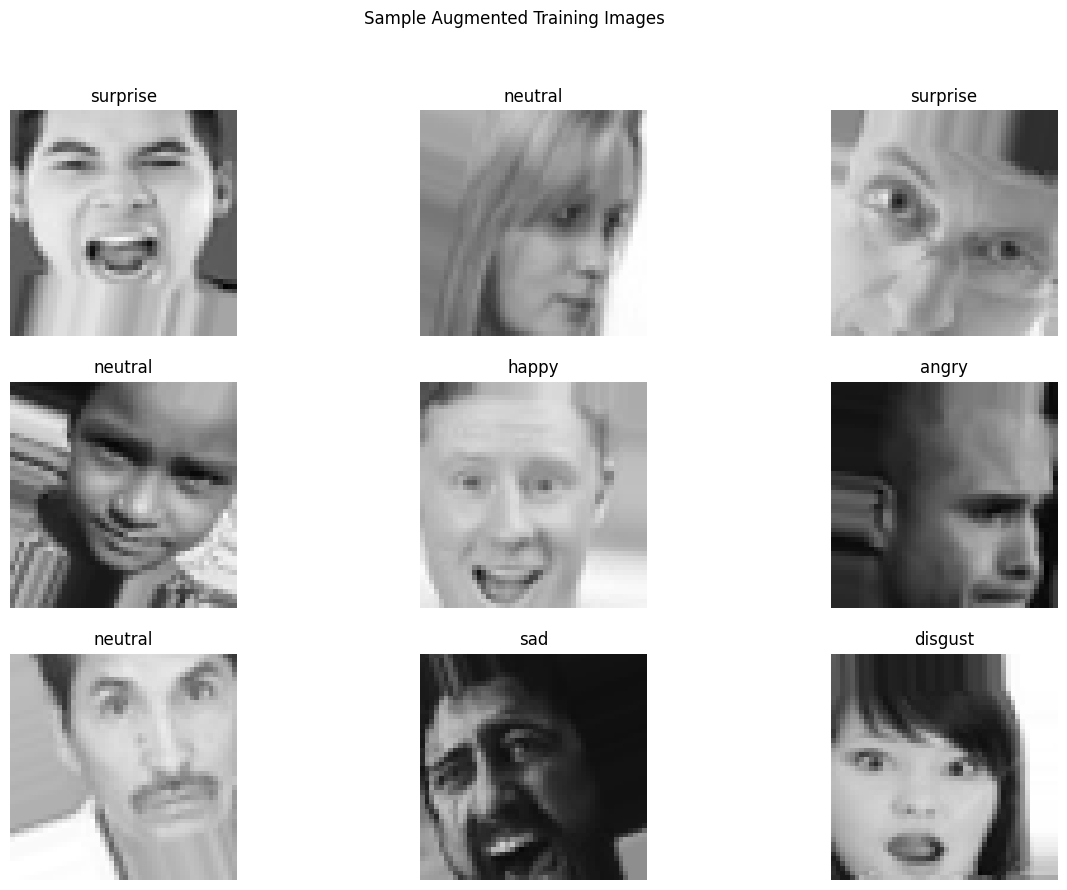

In [ ]:
# Visualizing some augmented images from training generator
train_images, train_labels_batch = next(train_generator)
plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i].squeeze(), cmap='gray')
    emotion_index = np.argmax(train_labels_batch[i])
    plt.title(emotions[emotion_index])
    plt.axis('off')
plt.suptitle("Sample Augmented Training Images")
plt.show()


***Simple CNN***

In [ ]:
# Simple CNN model
simple_cnn = Sequential()
# Block 1
simple_cnn.add(Conv2D(32, (3,3), activation='relu', input_shape=(48,48,3))) # Changed input_shape to 3 channels
simple_cnn.add(MaxPooling2D((2,2)))
simple_cnn.add(Dropout(0.25))
# Block 2
simple_cnn.add(Conv2D(64, (3,3), activation='relu'))
simple_cnn.add(MaxPooling2D((2,2)))
simple_cnn.add(Dropout(0.25))
# Block 3
simple_cnn.add(Conv2D(128, (3,3), activation='relu'))
simple_cnn.add(MaxPooling2D((2,2)))
simple_cnn.add(Dropout(0.25))
# Flatten and Dense layers
simple_cnn.add(Flatten())
simple_cnn.add(Dense(128, activation='relu'))
simple_cnn.add(Dropout(0.5))
simple_cnn.add(Dense(7, activation='softmax'))
# Compile the model
simple_cnn.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
simple_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,423 (1.36 MB)

 Trainable params: 356,423 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

***Train Simple CNN***

In [ ]:
# Training the simple CNN
epochs = 20

history_simple = simple_cnn.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=epochs,
    class_weight=class_weights
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 56s 55ms/step - accuracy: 0.1537 - loss: 1.9366 - val_accuracy: 0.1872 - val_loss: 1.9228
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.1801 - loss: 1.9179 - val_accuracy: 0.2017 - val_loss: 1.9102
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.1828 - loss: 1.9180 - val_accuracy: 0.1917 - val_loss: 1.9062
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.1887 - loss: 1.9262 - val_accuracy: 0.2382 - val_loss: 1.8847
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.1887 - loss: 1.9238 - val_accuracy: 0.2612 - val_loss: 1.8479
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.2081 - loss: 1.8849 - val_accuracy: 0.2289 - val_loss: 1.8416
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.1824 - loss: 1.8911 - val_accuracy: 0.1991 - val_loss: 1.8456
Epoch 8/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.1993 - loss: 1.8803 - val_accurac

***visualizes the Simple CNN model***

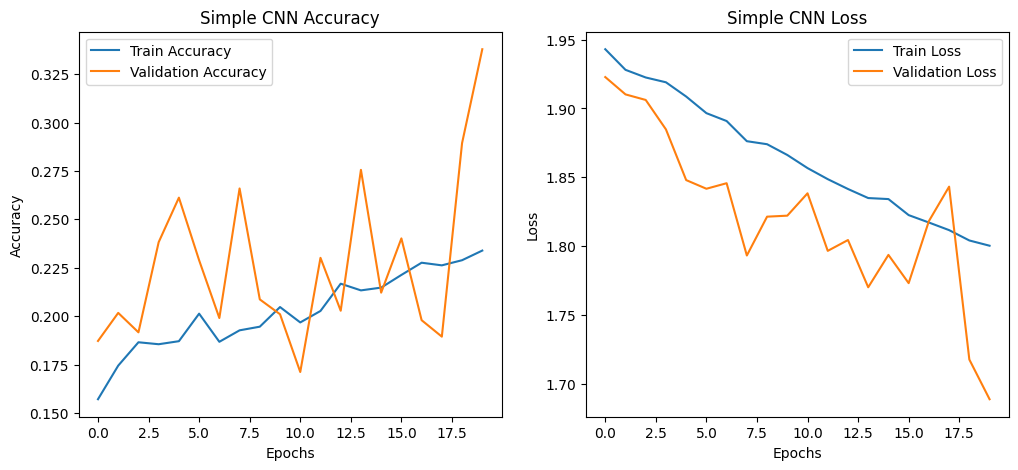

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_simple.history['accuracy'], label='Train Accuracy')
plt.plot(history_simple.history['val_accuracy'], label='Validation Accuracy')
plt.title("Simple CNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history_simple.history['loss'], label='Train Loss')
plt.plot(history_simple.history['val_loss'], label='Validation Loss')
plt.title("Simple CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

***Evaluate Simple CNN***

In [ ]:
test_steps = len(test_generator)
predictions = simple_cnn.predict(test_generator, steps=test_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)
# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step
Confusion Matrix:
 [[266 148  42 114 177 127  84]
 [ 21  55   3  11  11   6   4]
 [144 130  65 113 208 130 234]
 [211 240  38 566 412 191 116]
 [140 119  27 146 559 151  91]
 [171 175  27 205 277 319  73]
 [ 38  16  41  32  81  28 595]]
Classification Report:
               precision    recall  f1-score   support

       angry       0.27      0.28      0.27       958
     disgust       0.06      0.50      0.11       111
        fear       0.27      0.06      0.10      1024
       happy       0.48      0.32      0.38      1774
     neutral       0.32      0.45      0.38      1233
         sad       0.34      0.26      0.29      1247
    surprise       0.50      0.72      0.59       831

    accuracy                           0.34      7178
   macro avg       0.32      0.37      0.30      7178
weighted avg       0.36      0.34      0.33      7178



***Hybrid CNN Model***

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# Hybrid CNN Model
hybrid_cnn = Sequential()
# Block 1
hybrid_cnn.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48,48,3))) # Changed input_shape to 3 channels
hybrid_cnn.add(BatchNormalization())
hybrid_cnn.add(MaxPooling2D(pool_size=(2,2)))
hybrid_cnn.add(Dropout(0.25))
# Block 2
hybrid_cnn.add(Conv2D(64, (3,3), activation='relu', padding='same'))
hybrid_cnn.add(BatchNormalization())
hybrid_cnn.add(MaxPooling2D(pool_size=(2,2)))
hybrid_cnn.add(Dropout(0.25))
# Block 3
hybrid_cnn.add(Conv2D(128, (3,3), activation='relu', padding='same'))
hybrid_cnn.add(BatchNormalization())
hybrid_cnn.add(MaxPooling2D(pool_size=(2,2)))
hybrid_cnn.add(Dropout(0.25))
# Block 4
hybrid_cnn.add(Conv2D(256, (3,3), activation='relu', padding='same'))
hybrid_cnn.add(BatchNormalization())
hybrid_cnn.add(MaxPooling2D(pool_size=(2,2)))
hybrid_cnn.add(Dropout(0.25))
# Fully Connected Layers
hybrid_cnn.add(Flatten())
hybrid_cnn.add(Dense(256, activation='relu'))
hybrid_cnn.add(Dropout(0.5))
hybrid_cnn.add(Dense(7, activation='softmax'))  # 7 emotion classes
# Compile the model
hybrid_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hybrid_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 982,215 (3.75 MB)

 Trainable params: 981,255 (3.74 MB)

 Non-trainable params: 960 (3.75 KB)

***Training the Hybrid CNN Model***

In [ ]:
hybrid_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Train the model
history_hybrid = hybrid_cnn.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    class_weight=class_weights
)

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 60s 55ms/step - accuracy: 0.1316 - loss: 1.9564 - val_accuracy: 0.1733 - val_loss: 1.9474
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - accuracy: 0.1191 - loss: 1.9548 - val_accuracy: 0.1158 - val_loss: 1.9465
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 81s 47ms/step - accuracy: 0.0847 - loss: 1.9609 - val_accuracy: 0.2471 - val_loss: 1.9435
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.1966 - loss: 1.9542 - val_accuracy: 0.1718 - val_loss: 1.9449
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.1174 - loss: 1.9622 - val_accuracy: 0.1335 - val_loss: 1.9440
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - accuracy: 0.1474 - loss: 1.9368 - val_accuracy: 0.1427 - val_loss: 1.9449
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - accuracy: 0.1525 - loss: 1.9483 - val_accuracy: 0.1737 - val_loss: 1.9457
Epoch 8/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.0800 - loss: 1.9652 - 

***Visualizing Hybrid CNN Training***

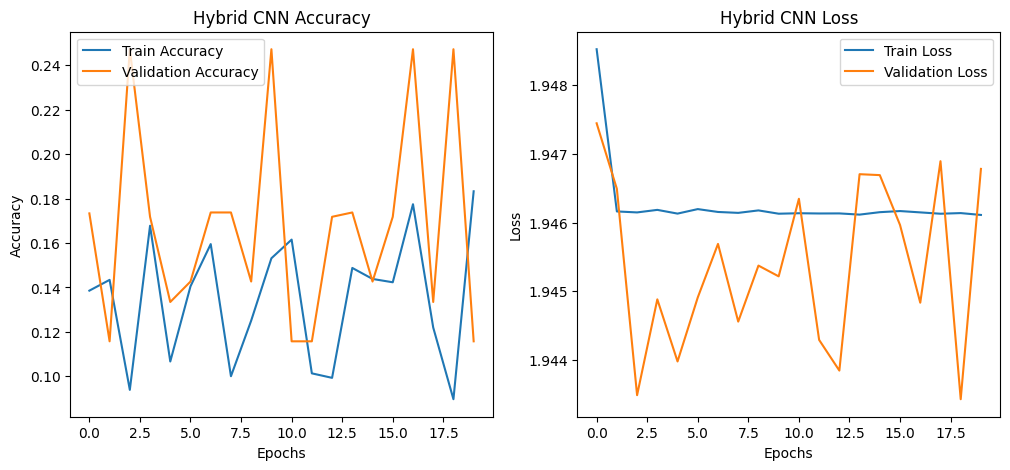

In [ ]:
plt.figure(figsize=(12,5))
# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_hybrid.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.title("Hybrid CNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
# Loss plot
plt.subplot(1,2,2)
plt.plot(history_hybrid.history['loss'], label='Train Loss')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss')
plt.title("Hybrid CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

***Evaluate Hybrid CNN on Test Set***

In [ ]:
test_steps = len(test_generator)
predictions_hybrid = hybrid_cnn.predict(test_generator, steps=test_steps, verbose=1)
predicted_classes_hybrid = np.argmax(predictions_hybrid, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
# Confusion Matrix
conf_matrix_hybrid = confusion_matrix(true_classes, predicted_classes_hybrid)
print("Confusion Matrix (Hybrid CNN):\n", conf_matrix_hybrid)
# Classification Report
report_hybrid = classification_report(true_classes, predicted_classes_hybrid, target_names=class_labels)
print("Classification Report (Hybrid CNN):\n", report_hybrid)

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Confusion Matrix (Hybrid CNN):
 [[   0    0    0    0    0    0  958]
 [   0    0    0    0    0    0  111]
 [   0    0    0    0    0    0 1024]
 [   0    0    0    0    0    0 1774]
 [   0    0    0    0    0    0 1233]
 [   0    0    0    0    0    0 1247]
 [   0    0    0    0    0    0  831]]
Classification Report (Hybrid CNN):
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.00      0.00      0.00      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.12      1.00      0.21       831

    accuracy                           0.12      7178
   macro avg       0.02      0.14      0.03      7178
weighted avg       0.01      0.12      0.02      7178



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


***Compare Accuracy and Loss of Simple vs Hybrid CNN***

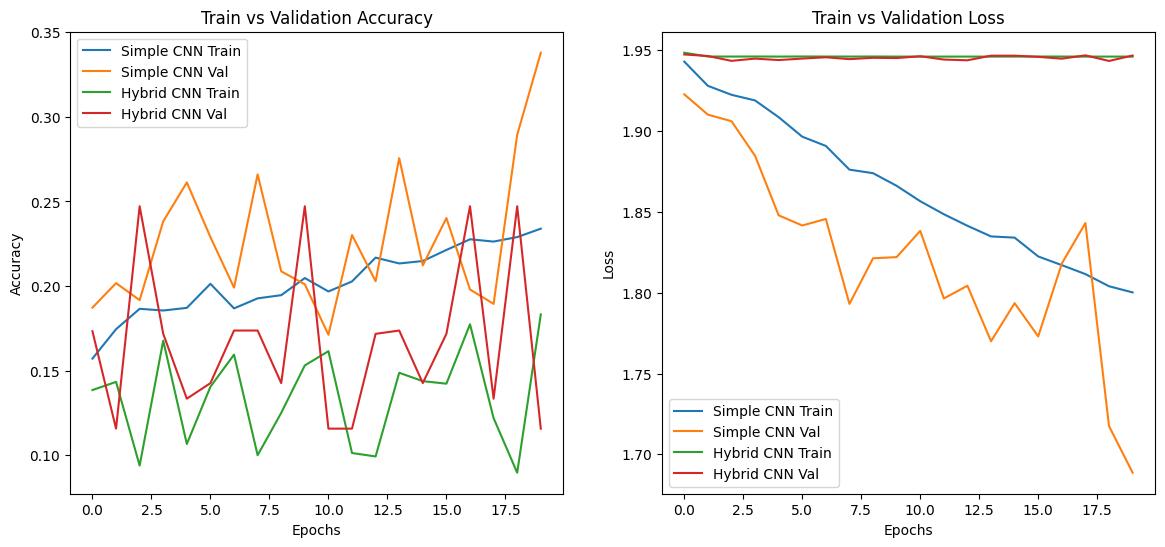

In [ ]:
plt.figure(figsize=(14,6))
# Accuracy
plt.subplot(1,2,1)
plt.plot(history_simple.history['accuracy'], label='Simple CNN Train')
plt.plot(history_simple.history['val_accuracy'], label='Simple CNN Val')
plt.plot(history_hybrid.history['accuracy'], label='Hybrid CNN Train')
plt.plot(history_hybrid.history['val_accuracy'], label='Hybrid CNN Val')
plt.title("Train vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
# Loss
plt.subplot(1,2,2)
plt.plot(history_simple.history['loss'], label='Simple CNN Train')
plt.plot(history_simple.history['val_loss'], label='Simple CNN Val')
plt.plot(history_hybrid.history['loss'], label='Hybrid CNN Train')
plt.plot(history_hybrid.history['val_loss'], label='Hybrid CNN Val')
plt.title("Train vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

***Load VGG16***

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
# Load base model (no top)
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(48,48,3))
# Unfreeze last convolution block (Block 5)
for layer in vgg_base.layers[:-4]:
    layer.trainable = False
for layer in vgg_base.layers[-4:]:
    layer.trainable = True
# Add better top layers
x = GlobalAveragePooling2D()(vgg_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(7, activation='softmax')(x)

model_vgg_improved = Model(inputs=vgg_base.input, outputs=output)

model_vgg_improved.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model_vgg_improved.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,110,471 (57.64 MB)

 Trainable params: 7,475,207 (28.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

***Train the model***

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_vgg16_improved.h5", monitor='val_accuracy', save_best_only=True)
]
history_vgg_improved = model_vgg_improved.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/25
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1870 - loss: 1.9740

898/898 ━━━━━━━━━━━━━━━━━━━━ 58s 57ms/step - accuracy: 0.1870 - loss: 1.9739 - val_accuracy: 0.3182 - val_loss: 1.8092
Epoch 2/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2491 - loss: 1.8413

898/898 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.2491 - loss: 1.8413 - val_accuracy: 0.3626 - val_loss: 1.7024
Epoch 3/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2826 - loss: 1.7763

898/898 ━━━━━━━━━━━━━━━━━━━━ 81s 51ms/step - accuracy: 0.2826 - loss: 1.7762 - val_accuracy: 0.3795 - val_loss: 1.6261
Epoch 4/25
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2951 - loss: 1.7493

898/898 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.2951 - loss: 1.7492 - val_accuracy: 0.4058 - val_loss: 1.5547
Epoch 5/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.3168 - loss: 1.6969 - val_accuracy: 0.3887 - val_loss: 1.5859
Epoch 6/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3317 - loss: 1.6793

898/898 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.3317 - loss: 1.6793 - val_accuracy: 0.4256 - val_loss: 1.5061
Epoch 7/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.3450 - loss: 1.6617 - val_accuracy: 0.4248 - val_loss: 1.5040
Epoch 8/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.3547 - loss: 1.6163 - val_accuracy: 0.3940 - val_loss: 1.5686
Epoch 9/25
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3666 - loss: 1.5959

898/898 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.3666 - loss: 1.5959 - val_accuracy: 0.4440 - val_loss: 1.4611
Epoch 10/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.3699 - loss: 1.5638 - val_accuracy: 0.4241 - val_loss: 1.4845
Epoch 11/25
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3799 - loss: 1.5620

898/898 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.3799 - loss: 1.5620 - val_accuracy: 0.4476 - val_loss: 1.4345
Epoch 12/25
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3829 - loss: 1.5417

898/898 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.3829 - loss: 1.5417 - val_accuracy: 0.4602 - val_loss: 1.4193
Epoch 13/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 48s 53ms/step - accuracy: 0.3938 - loss: 1.5325 - val_accuracy: 0.4468 - val_loss: 1.4355
Epoch 14/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 48s 53ms/step - accuracy: 0.4008 - loss: 1.5188 - val_accuracy: 0.4349 - val_loss: 1.4758
Epoch 15/25
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3999 - loss: 1.4982

898/898 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.3999 - loss: 1.4982 - val_accuracy: 0.4784 - val_loss: 1.3655
Epoch 16/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.4069 - loss: 1.4984 - val_accuracy: 0.4401 - val_loss: 1.4618
Epoch 17/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.4092 - loss: 1.4738 - val_accuracy: 0.4320 - val_loss: 1.4601
Epoch 18/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.4067 - loss: 1.4869 - val_accuracy: 0.4437 - val_loss: 1.4416
Epoch 19/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.4187 - loss: 1.4595 - val_accuracy: 0.4535 - val_loss: 1.4261
Epoch 20/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.4185 - loss: 1.4610 - val_accuracy: 0.4582 - val_loss: 1.4127


***Evaluate the model***

In [ ]:
test_steps = len(test_generator)
preds = model_vgg_improved.predict(test_generator, steps=test_steps)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
labels = list(test_generator.class_indices.keys())
# Confusion matrix + report
from sklearn.metrics import confusion_matrix, classification_report
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
Confusion Matrix:
[[ 367   27   41  102  247  119   55]
 [  15   57    5   13   14    6    1]
 [ 150   26  124  114  266  165  179]
 [ 118   27   23 1153  293   74   86]
 [  84   16   39  137  789  120   48]
 [ 175   19   58  188  399  361   47]
 [  51    3   33   38  109   14  583]]

Classification Report:
              precision    recall  f1-score   support

       angry       0.38      0.38      0.38       958
     disgust       0.33      0.51      0.40       111
        fear       0.38      0.12      0.18      1024
       happy       0.66      0.65      0.66      1774
     neutral       0.37      0.64      0.47      1233
         sad       0.42      0.29      0.34      1247
    surprise       0.58      0.70      0.64       831

    accuracy                           0.48      7178
   macro avg       0.45      0.47      0.44      7178
weighted avg       0.48      0.48      0.46      7178



***Visualize VGG16***

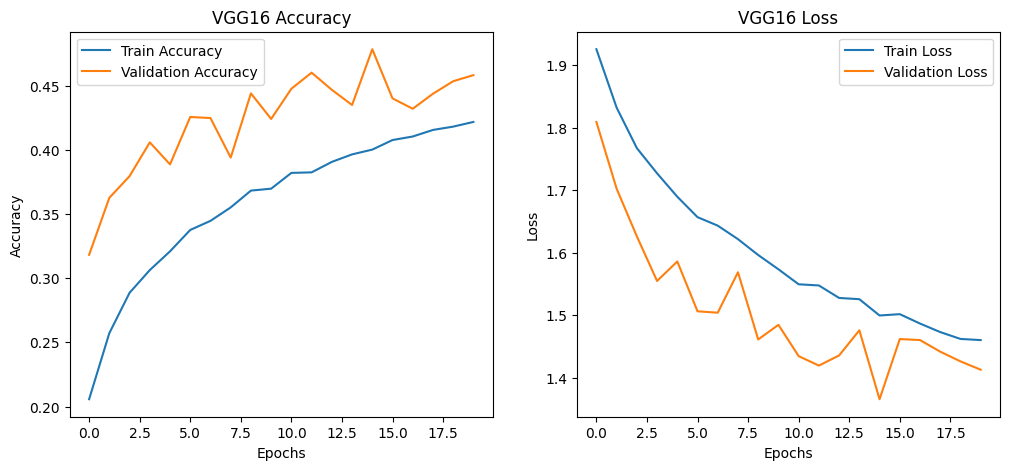

In [ ]:
plt.figure(figsize=(12,5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(history_vgg_improved.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg_improved.history['val_accuracy'], label='Validation Accuracy')
plt.title("VGG16 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
# Loss
plt.subplot(1,2,2)
plt.plot(history_vgg_improved.history['loss'], label='Train Loss')
plt.plot(history_vgg_improved.history['val_loss'], label='Validation Loss')
plt.title("VGG16 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

***COMPARISON: Simple CNN vs Hybrid CNN vs VGG16***

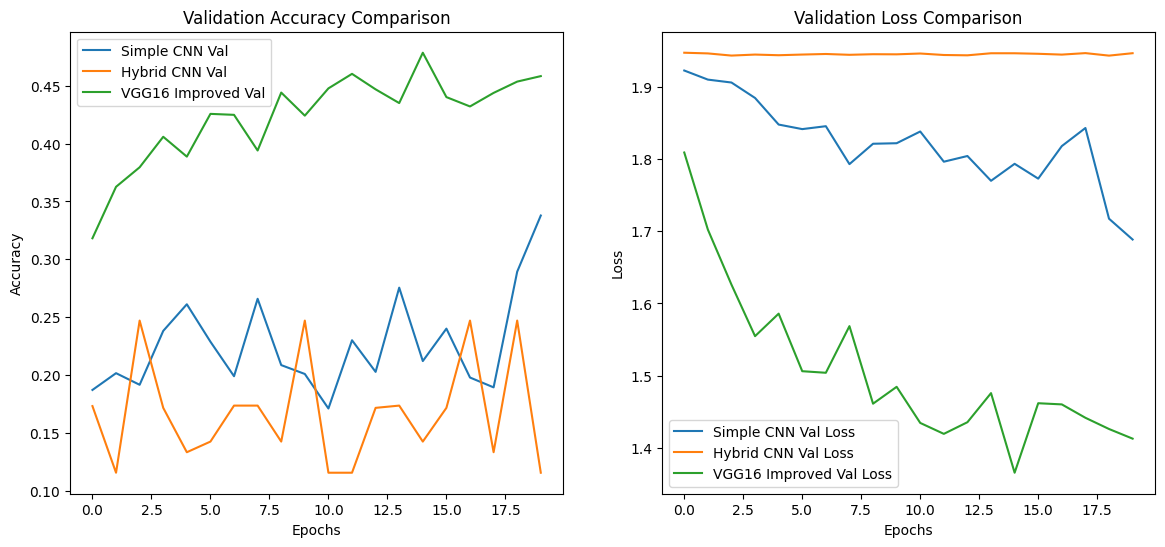

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(history_simple.history['val_accuracy'], label='Simple CNN Val')
plt.plot(history_hybrid.history['val_accuracy'], label='Hybrid CNN Val')
plt.plot(history_vgg_improved.history['val_accuracy'], label='VGG16 Improved Val')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
# ---- LOSS ----
plt.subplot(1,2,2)
plt.plot(history_simple.history['val_loss'], label='Simple CNN Val Loss')
plt.plot(history_hybrid.history['val_loss'], label='Hybrid CNN Val Loss')
plt.plot(history_vgg_improved.history['val_loss'], label='VGG16 Improved Val Loss')
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()